In [30]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parsing_utils import *
from utils.utils import *
from scripts.parse_results import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
COLORS = {}
#COLORS["Optimizer Loss"] = "blue"
# COLORS["MSCN - Optimizer Loss"] = "blue"
# COLORS["MSCN - Priority"] = "purple"
# COLORS["MSCN - Q-Error"] = "green"

COLORS["Optimizer-Cost"] = "blue"
COLORS["Q-Error"] = "green"


ALG_KEY = {}
ALG_KEY["flow_loss2"] = "Optimizer-Cost"
ALG_KEY["mse"] = "Q-Error"


ALG_KEY["postgres"] = "Postgres"
ALG_KEY["true"] = "True"

#TITLE_FMT = "{SAMPLES}-{PARTITION}"
TITLE_KEYS = {}
TITLE_KEYS["job"] = "Join Order Benchmark"
TITLE_KEYS["test"] = "Test Set"
TITLE_KEYS["train"] = "Train Set"

In [32]:
#RES_DIR = "/home/pari/learned-cardinalities/all_results/vldb/default/hyp_sweep2"
#RES_DIR = "/home/pari/learned-cardinalities/all_results/vldb/default/hyp_sweep_fcnn"

#RES_DIR = "/home/ubuntu/learned-cardinalities/all_results/vldb/default/fcnn_ablation"
RES_DIR = "/home/ubuntu/learned-cardinalities/all_results/vldb/test_diff/fcnn/ablation/"

#RES_DIR = "/home/pari/learned-cardinalities/all_results/vldb/default/hyp_sweep3"

#RES_DIR = "/home/pari/learned-cardinalities/all_results/vldb/test_diff/mscn/best_hyp_run1"
#all_results/vldb/default/hyp_sweep2

#RES_DIR3 = "/home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/nested_loop_index7/test_diff/final_results_new_seeds/"
#RES_DIR = "/home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/nested_loop_index7/test_diff/final_results_new_seeds_wd1"


RES_DIRS = []
RES_DIRS.append(RES_DIR)
#RES_DIRS.append(RES_DIR2)
#RES_DIRS.append(RES_DIR3)
#RES_DIRS.append(RES_DIR4)

OVERLAP_INFO = "./all_results/3/overlap_info.pkl"

dfs = []
qerr_all = []
for res_dir in RES_DIRS:
    print(res_dir)
    df = get_summary_df(res_dir)
#     qerr = get_all_objects(res_dir, "all_qerr.pkl")
#     qerr_all.append(qerr)
    
    df["res_dir"] = str(deterministic_hash(res_dir))[0:5]
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
#qerrs = pd.concat(qerr_all, ignore_index=True)

/home/ubuntu/learned-cardinalities/all_results/vldb/test_diff/fcnn/ablation/

skipping1  /home/ubuntu/learned-cardinalities/all_results/vldb/test_diff/fcnn/ablation//runAllDiff-nested_loop_index7-msft-df:10-nn:4:512-loss:mse-0.0--D0.1-117968

skipping1  /home/ubuntu/learned-cardinalities/all_results/vldb/test_diff/fcnn/ablation//runAllDiff-nested_loop_index7-msft-df:10-nn:4:512-loss:flow_loss2-0.0--D1.0-122475

skipping1  /home/ubuntu/learned-cardinalities/all_results/vldb/test_diff/fcnn/ablation//runAllDiff-nested_loop_index7-msft-df:10-nn:4:512-loss:mse-0.0--D0.1-569412

skipping1  /home/ubuntu/learned-cardinalities/all_results/vldb/test_diff/fcnn/ablation//runAllDiff-nested_loop_index7-msft-df:10-nn:4:512-loss:flow_loss2-no_pg_ests-0.0--D1.0-132718


In [33]:
df = df[df["alg_name"] != "true"]
df = df[df["alg_name"] != "postgres"]
#df = df[df["weight_decay"] == 0.1]

print(set(df["alg_name"]))
print(set(df["nn_type"]))
print(set(df["flow_features"]))
print(set(df["sample_bitmap"]))
print(set(df["feat_rel_pg_ests_onehot"]))
print(set(df["hidden_layer_size"]))
print(set(df["test_size"]))
print(set(df["weight_decay"]))
print(set(df["max_epochs"]))
#print(set(df["fn"]))

{'mse', 'flow_loss2'}
{'microsoft'}
{0, 1}
{0}
{1}
{512}
{0.5}
{0.1, 1.0}
{10, 15}


In [34]:
df["loss"] = abs(df["loss"])

In [35]:
#ERRORS = ["qerr", "plan_pg_err", "jerr", "cm1_jerr"]
ERRORS = ["qerr", "flow_err", "plan_err", "jerr", "cm1_jerr"]

COLORS = ["blue", "green", "orange", "red", "black", "violet", "lightblue", "gray"]
#MSE_COLOR = "blue"

#cols = ["alg_name", "hidden_layer_size", "num_hidden_layers", "sample_bitmap"]
#cols = ["alg_name", "flow_features"]

cols = ["alg_name", "sampling_priority_alpha", "weight_decay"]
#cols = ["alg_name", "fn_hash"]
df['alg_name'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
#df.loc[df['alg_name'] == "flow_loss2_0_1", ["alg_name"]] = "flow_loss2_0_0"

all_df = df[df["template"] != "all"]
df = df[df["template"] == "all"]
df = df[df["summary_type"] == "mean"]
#df = df[df["num_tables"] == "all"]
df = df[df.debug_set == 0]

print("additional default filters")

df = df[df.test_size == 0.5]

print("not restricting to 10 buckets")
#df = df[df.max_discrete_featurizing_buckets == 10]
#df = df[df.hidden_layer_size == 256]


#df = df[df["flow_features"] == 1]
#ORDER = ["mse", "flow_loss2"]

ORDER = []
HUE_COLORS = {}
#HUE_COLORS = None

algs = list(set(df["alg_name"]))
algs.sort()
for i,alg in enumerate(algs):
    HUE_COLORS[alg] = COLORS[i]
    ORDER.append(alg)

    #if "mse" in alg:
    #    HUE_COLORS[alg] = MSE_COLOR
    #else:
    #    HUE_COLORS[alg] = COLORS[i]


additional default filters
not restricting to 10 buckets


In [36]:
print(set(df["loss_type"]))
print(set(df["max_epochs"]))
print(set(df["alg_name"]))
print(set(df["debug_set"]))
print(set(df["flow_features"]))
print(set(df["table_features"]))
print(set(df["pred_features"]))
print(set(df["join_features"]))
print(set(df["heuristic_features"]))
print(set(df["lr"]))
print(set(df["feat_rel_pg_ests"]))
print(set(df["use_set_padding"]))
print(set(df["loss_func"]))
print(set(df["normalize_flow_loss"]))

{'qerr', 'cm1_jerr'}
{10, 15}
{'mse_0.0_0.1', 'flow_loss2_0.0_1.0'}
{0}
{0, 1}
{0, 1}
{0, 1}
{0, 1}
{0, 1}
{1e-05, 0.0001}
{1}
{3}
{'mse', 'flow_loss2'}
{0}


In [23]:
df["loss_func"] = df.apply(lambda x: ALG_KEY[x["loss_func"]],axis=1)

In [24]:
#df = df[df["fn"] != "runAllDiff-nested_loop_index7-msft-df:10-nn:4:512-loss:flow_loss2-0.0--D1.0-115034"]

In [25]:
pd.set_option('display.max_rows', 500)
#cur_df = df[df.samples_type == "test"]
cur_df = df
#cur_df = cur_df[cur_df.loss_type == "cm1_jerr"]
cur_df = cur_df[cur_df.loss_type.isin(["cm1_jerr", "qerr"])]

#cur_df = cur_df[cur_df.loss_func == "flow_loss2"]
#cur_df = cur_df[cur_df.loss_func == "mse"]
#cur_df = cur_df[cur_df.samples_type == "test"]

# cur_df.groupby(["loss_func", "heuristic_features", "flow_features", 
#                 "table_features", "pred_features", "join_features",
#                 "loss_type", "samples_type"]).describe()["loss"]

In [26]:
def get_ablation_name(row):
    if row["heuristic_features"] == 0 and row["flow_features"] == 0:
        return "No PostgreSQL\n Estimates"
    elif row["flow_features"] == 0 and row["heuristic_features"] == 1:
        return "No Global Features"
    elif row["table_features"] == 0 and row["pred_features"] == 0 and row["join_features"] == 0:
        return "No Table, Join,\n Predicate Features"
    elif row["table_features"] == 0 and row["join_features"] == 0 and row["pred_features"] == 1:
        return "No Table,\n Join Features"
    elif row["table_features"] == 0 and row["pred_features"] == 0 and row["join_features"] == 1:
        return "No Table,\n Predicate Features"
    elif row["table_features"] == 0:
        return "No Table Features"
    elif row["pred_features"] == 0:
        return "No Predicate Features"
    elif row["join_features"] == 0:
        return "No Join Features" 
    else:
        return "Unknown"

In [27]:
cur_df["Ablation"] = cur_df.apply(lambda row: get_ablation_name(row) ,axis=1)

In [28]:
cur_df = cur_df[cur_df["Ablation"] != "Unknown"]

In [29]:
table_ab = cur_df[cur_df["Ablation"] == "No Table Features"]
table_ab.groupby(["partition", "fn", "loss_type", "samples_type"]).describe()["loss"]

count  \
partition fn                                                 loss_type samples_type          
1         runAllDiff-nested_loop_index7-msft-df:10-nn:4:5... cm1_jerr  test            1.0   
                                                                       train           1.0   
                                                             qerr      test            1.0   
                                                                       train           1.0   
          runAllDiff-nested_loop_index7-msft-df:10-nn:4:5... cm1_jerr  test            1.0   
                                                                       train           1.0   
                                                             qerr      test            1.0   
                                                                       train           1.0   
2         runAllDiff-nested_loop_index7-msft-df:10-nn:4:5... cm1_jerr  test            1.0   
                                                                       train           1.0   
                                                             qerr      test            1.0   
                                                                       train           1.0   
          runAllDiff-nested_loop_index7-msft-df:10-nn:4:5... cm1_jerr  test            1.0   
                                                                       train           1.0   
                                                             qerr      test            1.0   
                                                                       train           1.0   
3         runAllDiff-nested_loop_index7-msft-df:10-nn:4:5... cm1_jerr  test            1.0   
                                                                       train           1.0   
                                                             qerr      test            1.0   
                                                                       train           1.0   
          runAllDiff-nested_loop_index7-msft-df:10-nn:4:5... cm1_jerr  test            1.0   
                                                                       train           1.0   
                                                             qerr      test            1.0   
                                                                       train           1.0   
4         runAllDiff-nested_loop_index7-msft-df:10-nn:4:5... cm1_jerr  test            1.0   
                                                                       train           1.0   
                                                             qerr      test            1.0   
                                                                       train           1.0   
          runAllDiff-nested_loop_index7-msft-df:10-nn:4:5... cm1_jerr  test            1.0   
                                                                       train           1.0   
                                                             qerr      test            1.0   
                                                                       train           1.0   
5         runAllDiff-nested_loop_index7-msft-df:10-nn:4:5... cm1_jerr  test            1.0   
                                                                       train           1.0   
                                                             qerr      test            1.0   
                                                                       train           1.0   
          runAllDiff-nested_loop_index7-msft-df:10-nn:4:5... cm1_jerr  test            1.0   
                                                                       train           1.0   
                                                             qerr      test            1.0   
                                                                       train           1.0   
6         runAllDiff-nested_loop_index7-msft-df:10-nn:4:5... cm1_jerr  test            1.0   
                                           

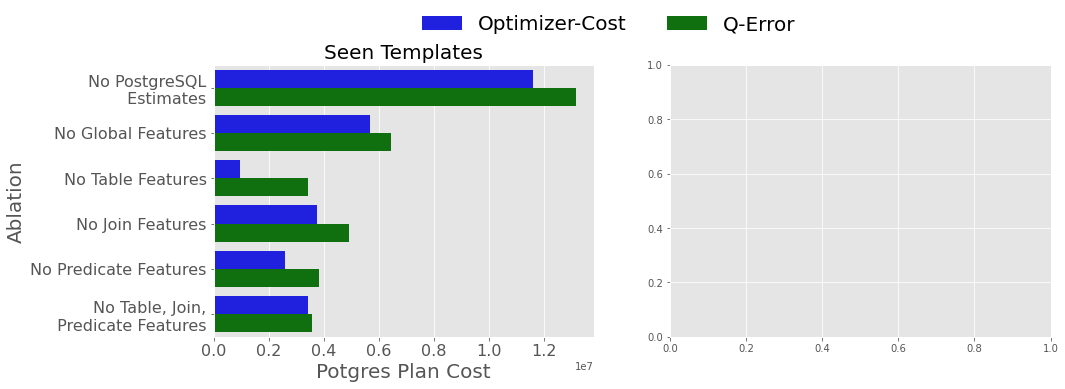

In [16]:
ORDER = ["No PostgreSQL\n Estimates", "No Global Features", "No Table Features", "No Join Features", 
         "No Predicate Features", "No Table, Join,\n Predicate Features"]
from matplotlib.container import ErrorbarContainer
from matplotlib.legend_handler import HandlerErrorbar
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FixedLocator)

fig, axs = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
plt.style.use('ggplot')

jerrs = cur_df[cur_df.loss_type == "cm1_jerr"]
jerrs1 = jerrs[jerrs.samples_type == "test"]
ax = axs[0]
sns.barplot(data=jerrs1, x="loss", y="Ablation", hue="loss_func", orient="h", palette=COLORS, ax=ax, ci=None, 
            order=ORDER)
ax.set_xscale("linear")
ax.set_ylabel("Ablation", fontsize=20)
ax.set_xlabel("Potgres Plan Cost", fontsize=20)
ax.set_title("Seen Templates", fontsize=20)

ax.tick_params(axis='y', which='minor', labelsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)


with plt.style.context('default'):
    ax.legend(title="", loc="center left", bbox_to_anchor=(0.50, 1.15), ncol=2, fontsize=20, 
                frameon=False)

# jerrs2 = jerrs[jerrs.samples_type == "job"]

# ax = axs[1]
# sns.barplot(data=jerrs2, x="loss", y="Ablation", hue="loss_func", orient="h", palette=COLORS, ax=ax, ci=None, 
#            order=ORDER)
# ax.set_xscale("log")
# ax.set_yticks([])
# ax.set_ylabel("")
# ax.set_xlabel("Potgres Plan Cost", fontsize=20)
# ax.legend().remove()
# ax.set_title("Join Order Benchmark", fontsize=20)
# ax.tick_params(axis='y', which='minor', labelsize=16)
# ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()
